$
\newcommand{\Tau}{\mathcal{T}}
\newcommand{\bm}[1]{{\boldsymbol{#1}}}
\newcommand{\dt}[1]{{\frac{d#1}{dt}}}
%\newcommand{\bm}{\mathbf{#1}}
\newcommand{\trsp}{{\scriptscriptstyle\top}}$

In [1]:
import numpy as np
import pbdlib as pbd
import matplotlib.pyplot as plt
from IPython.core import display

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Product of Bayesian GMM and LQR

This notebook demonstrates how to stabilize a policy learned by imitation by fusing it with another converging policy. The Bayesian uncertainty of the imitation policy is used in the fusion rule, in a way that, when very unsure, the converging *"default"* policy is used. 

## Loading synthetic demonstration trajectories

The demonstrations consists of point-to-point trajectories converging at a known position. This point-to-point property makes it possible to use simple converging policies, such as an LQR. Other approaches are investigated in the paper for more generic tasks, for example implying periodic motions.

In [17]:
demo_name = 'policy_001'
data = np.load('./data/%s.npy' % demo_name)[()]

#### Retrieve position and velocity 

In [18]:
x_in = np.concatenate(data['x'], axis=0)  # position is the state \xi
x_out = np.concatenate(data['dx'], axis=0)  # velocity is the control command \u
x_joint = np.concatenate([x_in, x_out], axis=1)

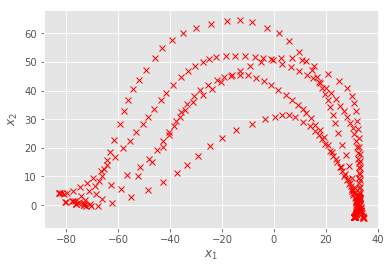

In [19]:
plt.plot(x_in[:, 0], x_in[:, 1], 'rx')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

In [8]:
n_in = x_in.shape[1]  # dimension of state \xi - position
n_out = x_out.shape[1]  # dimension of control commmand \u - velocity
n_joint = x_joint.shape[1]  # dimension of joint space \xi \u
n_data = x_joint.shape[0]  # number of samples

## Imitation policy - Learning Bayesian Gaussian Mixture model

The approach is to learn the joint distribution of state and control command $p(\bm{X}, \bm{U})$
and apply conditioning to retrieve a policy $p(\bm{u}| \bm{x})$.

The joint distribution is modeled as a Gaussian mixture model, whose posterior distribution $p(\bm{\theta}|\bm{X}, \bm{U})$ is approximated using mean-field variational inference.

Uncertainty about the model is propagated to the control command with the predictive posterior distribution 

\begin{align}
p(\bm{u}|\bm{x}, \bm{X}, \bm{U}) =
\int_{\bm{\theta}} p(\bm{u}|\bm{x}, \bm{\theta})p(\bm{\theta}|\bm{X}, \bm{U})d\bm{\theta},
\end{align}

providing a notion of uncertainty in unknown area.

Implementation is based on scikit-learn. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.BayesianGaussianMixture.html#sklearn.mixture.BayesianGaussianMixture) for parameters.

In [10]:
joint_model = pbd.VBayesianGMM({
        'n_components':23, 'n_init':1, 'reg_covar': 0.6 ** 2,
        'covariance_prior': 14. ** 2 * np.eye(4), 'mean_precision_prior':20. ** -2,
        'weight_concentration_prior_type':'dirichlet_process', 'weight_concentration_prior': 1e3,
        'degrees_of_freedom_prior': n_joint - 1. + 0.3 })

In [11]:
# approximate posterior distribution of GMM
joint_model.posterior(data=x_joint)

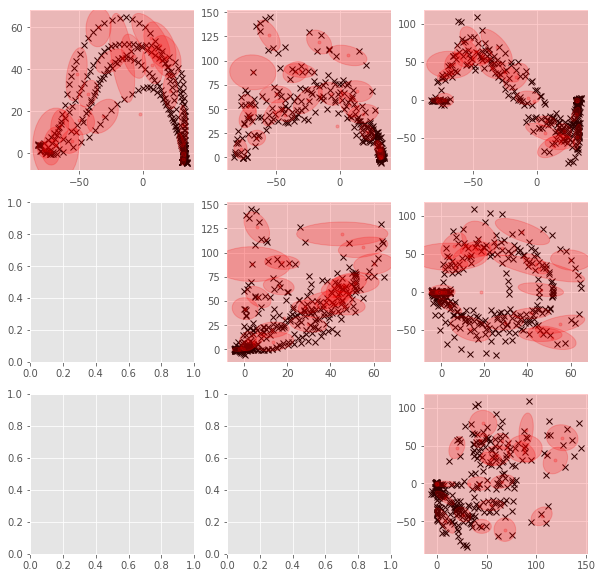

In [13]:
# display distribution
fig, ax = plt.subplots(nrows=n_joint-1, ncols=n_joint-1, figsize=(10, 10))

for i in range(n_joint):
    for j in range(n_joint):
        if not i == j and j>i:
            ax[i][j-1].plot(x_joint[:, i], x_joint[:, j], 'kx')
            ax[i][j-1].autoscale(False)
            joint_model.plot(dim=[i, j], ax=ax[i][j-1], alpha=0.2)

In [20]:
# compute conditional predictive distribution (1)
# p(u|x, X, U) which is a mixture of multivariate t distribution is approximated 
# with a Gaussian with moment matching

def f(x, use_gmr=False):
    return joint_model.condition(x, slice(0, n_in), slice(n_in, n_joint))[0]

In [21]:
# get log determinant of p(u|x, X, U) approximated with a Gaussian
def uncertainty(x):
    return -np.log(joint_model.get_pred_post_uncertainty(x, slice(0, n_in), slice(n_in, n_joint)))

### Bayesian DP-GMM policy 
Display policy and uncertainty as a heatmap

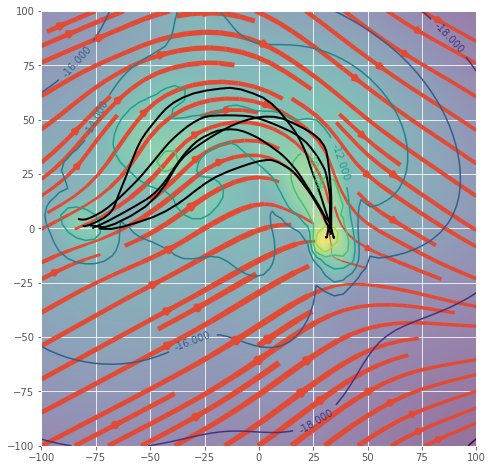

In [23]:
plt.figure(figsize=(8, 8))

pbd.plot_dynamic_system(f, xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.05)
pbd.plot_function_map(uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=80, opp=False)

# joint_model.plot(dim=[0, 1], alpha=0.2)
for d in data['x']:
    plt.plot(d[:, 0], d[:, 1], 'k', lw=2)

## LQR - stable controller 
We create another policy/controller, whose goal is to converge at the same final state distribution as the demonstrated trajectories and also stay in the same distribution at anytime.

In [25]:
dt = 0.05

# our system is velocity controlled, we have a simple integrator
A = np.eye(2)
B = dt * np.eye(2) 
T = max([d.shape[0] for d in data['x']]) + 50

lqr = pbd.LQR(A, B, horizon=T)

In [27]:
# we create nb_states=2 MVNs whose negative log prob (quadratic) 
# will be used as cost for the LQR 
cost_xi = pbd.GMM(nb_states=2, nb_dim=2) 

diag = lambda x: np.eye(x.shape[-1]) * x

# get mean state value
cost_xi.mu = np.array([
    # data distribution - where it needs to stay at any time
    np.mean(x_joint[:, :2], axis=0), 
    # end state distribution - where it needs to converge
    np.mean([d[-1] for d in data['x']], axis=0)
])

cost_xi.sigma = [
    # data distribution - where it needs to stay at any time
    # allow 8 more variability - sqrt(8) in std
    8 * diag(np.cov(x_joint[:, :2], rowvar=False)), 
    # end state distribution - where it needs to converge
    # allow 2 times more variability 
    4 * diag(np.cov([d[-1] for d in data['x']],rowvar=False)) 
]

# create MVN for the distribution of control command
cost_u = pbd.MVN(nb_dim=2)

cost_u.mu = np.zeros(2)  # zero centered
cost_u.sigma = 8. * diag(np.cov(x_joint[:, 2:], rowvar=False))  # more velocity is allowed than in the demo

In [28]:
# track data distribution for T-50 first time steps and final state distribution after
lqr.gmm_xi = cost_xi, [0 for i in range(T - 50)] + [1 for i in range(50)]
# regularize with zero centered velocity distribution 
lqr.gmm_u = cost_u

In [30]:
# solve ricatti
lqr.ricatti()

In [35]:
# get time-dependent stable policy and 
# its variabilty (curvature of the solution, follows maximum entropy principle)

def stable_policy(x, t=0):
    return np.einsum('ij,ai->aj', lqr.K[t], lqr.ds[t]-x), lqr.Q[t] * np.ones_like(x)[:, :, None]

Solution of LQR gives a distribution of policy on the form of 
\begin{align}
p(\bm{u}_t|\bm{x}_t) = \mathcal{N}(-\bm{K}_t \bm{x}_t + \bm{c}_t, \bm{Q}_t^{-1}).
\end{align}

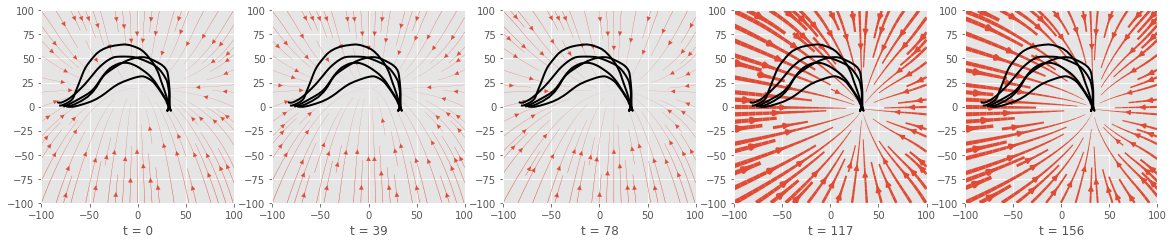

In [38]:
# display how the policy change accross time 
# becomes more and more convergent to ensure convergence at the desired final distribution 
n = 5
fig, ax = plt.subplots(ncols=n, figsize=(4* n, 4))

for i, t in enumerate(np.linspace(0, T-2, n)):
    pbd.plot_dynamic_system(
        lambda x: stable_policy(x, t=int(t))[0],
        xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.002, ax=ax[i])
    
    ax[i].set_xlabel('t = %d' % t)

    for d in data['x']:
        ax[i].plot(d[:, 0], d[:, 1], 'k', lw=2)

## Product of policies 
We have now two distributions of control command as MVN distribution  $\mathcal{N}_i(\bm{x}|\, \bm{\mu}_i, \bm{\Lambda}^{-1}_{i})$ for $i \in \{1, 2\}$  that we fuse using Product of Gaussian.

\begin{align}
\bar{\bm{\Lambda}} = \sum_{i=1}^{M} \bm{\Lambda}_i,\quad \bar{\bm{\mu}} = \bar{\bm{\Lambda}}^{-1}\sum_{i=1}^{M} \bm{\Lambda}_i \bm{\mu}_i,
\end{align}

The resulting control command is a weighted sum of the control command, where the weights are given by the precision matrix (inverse of covariance).

In [39]:
def product_policy(x, t=0):
    mu_1, sigma_1 = joint_model.condition(x, slice(0, n_in), slice(n_in, n_joint))
    mu_2, sigma_2 = stable_policy(x, t)
    
    lmbda_1, lmbda_2 = np.linalg.inv(sigma_1), np.linalg.inv(sigma_2) 
    lmbda_p = lmbda_1 + lmbda_2
    
    mu_p = np.einsum('aij,aj->ai',np.linalg.inv(lmbda_p),(np.einsum('aij,aj->ai', lmbda_1, mu_1) +
     np.einsum('aij,aj->ai', lmbda_2, mu_2)))
    return mu_p

In [41]:
# compute rollout
xis = [np.copy(data['x'][2][0])]

for i in range(0, T-6):
    u = product_policy(xis[-1][None], i)[0]
    xis += [A.dot(xis[-1]) + B.dot(u)]
    
xis = np.array(xis)

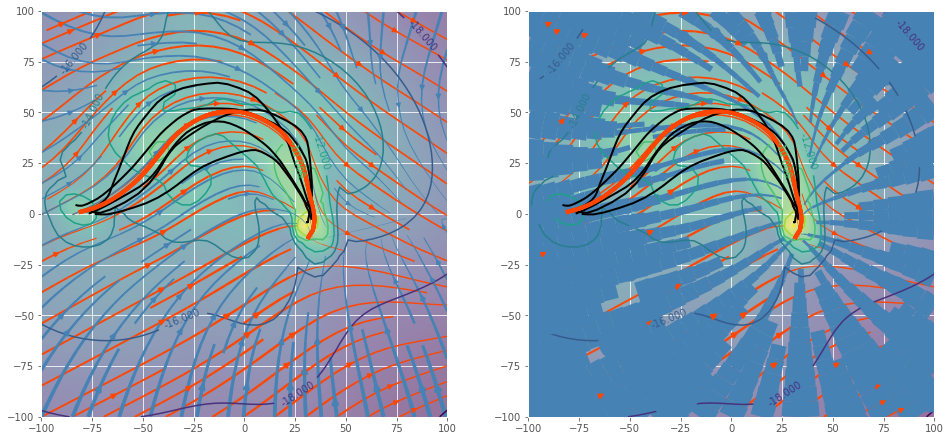

In [47]:
fig, ax= plt.subplots(ncols=2, figsize=(16, 8))

# overlay with imitation policy
for i in range(2):
    pbd.plot_dynamic_system(
        f, xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.02, ax=ax[i], color='orangered')

pbd.plot_dynamic_system(
    lambda x: product_policy(x, t=0),
    xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.02, ax=ax[0],
    color='steelblue'
)

pbd.plot_dynamic_system(
    lambda x: product_policy(x, t=-50),
    xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.02, ax=ax[1],
    color='steelblue'
)


for i in range(2):
    pbd.plot_function_map(
        uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=40, opp=False, ax=ax[i])

    for d in data['x']:
        ax[i].plot(d[:, 0], d[:, 1], 'k', lw=2)

        ax[i].plot(xis[:, 0], xis[:, 1], lw=4, color='orangered')

### Recording video 

In [26]:
import imageio
import os

In [27]:
images = []
name = demo_name + '_dp_gmm_lqr'
# for t in range(0, 6, 6):
for t in range(0, T-6, 3):
    plt.figure(figsize=(8, 8))
    
    pbd.plot_dynamic_system(
        lambda x: product_policy(x, t=t),
        xlim=[-100, 100], ylim=[-100, 100], equal=True, scale=0.03,
        color='steelblue'
    )
    
    pbd.plot_function_map(
        uncertainty, xlim=[-100, 100], ylim=[-100, 100], nb_sub=40, opp=False)
    
    for d in data['x']:
        plt.plot(d[:, 0], d[:, 1], 'k--', lw=2, alpha=0.6)
        
    plt.plot(xis[:t, 0], xis[:t, 1], color='orangered', lw=3)
    plt.plot(xis[t, 0], xis[t, 1], 'ws', mec='orangered', ms=10, mew=2)
    
    plt.savefig('img_%d.png' % t)
    
    images.append(imageio.imread('img_%d.png' % t))
    os.remove('img_%d.png' % t)
    plt.close()
    
imageio.mimsave('%s.mp4' % name, images)